# **Lab 5: Title**
**Christoffer Ejemyr**

# **Abstract**

This lab describes and shows some of the integrationsmaethods that can beused to approximate integrals to a certain degree of accurasy. They are shown to meat the requirements expected.

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Christoffer Ejemyr (ejemyr@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
# from google.colab import files

import time
import numpy as np
import unittest
from typing import Callable, Tuple

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.optimize import curve_fit

class Tests(unittest.TestCase):
    @staticmethod
    def check_accuracy(est: np.ndarray, true: np.ndarray, decimal: int):
        np.testing.assert_almost_equal(est, true, decimal=decimal)

    @staticmethod
    def check_accuracy_multiple_random(num_of_tests, generating_func, decimal):
        for i in range(num_of_tests):
            est, true = generating_func()
            Tests.check_accuracy(est, true, decimal)


# **Introduction**

In this lab we will investigate some of the different methods of integration that can be ussed to approximate an integral.

# **Methods**

### Usefull stuff

In [3]:
Interval = Tuple[float, float]

### 2-point Gauss quadrature
To understand explcitly how our very limited method should work we use equation (11.4) in the lecture notes. With example 11.3 we have that the 2-point Gauss quadrature should span $P^3([a, b])$. On the interval $(0,1)$ we have

\begin{align}
    \int_0^1 p(x) &= p_0(x_0) w_0 + p_1(x_1) w_1 \\
    \int_0^1 \sum_{i=0}^3 c_i x^i &= w_0\sum_{i=0}^3 c_i x_0^i + w_1\sum_{i=0}^3 c_i x_1^i \\
    \sum_{i=0}^3 \frac{c_i}{i+1} - w_0\sum_{i=0}^3 c_i x_0^i - w_1\sum_{i=0}^3 c_i x_1^i &= 0 \\
    \sum_{i=0}^3 c_i(\frac{1}{i+1} - w_0 x_0^i - w_1 x_1^i) &= 0.
\end{align}
Which for arbitrary $c_i$ ($i=0,1,2,3$) gives

$$\frac{1}{i+1} - w_0 x_0^i - w_1 x_1^i = 0.$$

We get $w_0 = \frac{1}{2}$, $x_0 = \frac{3 - \sqrt{3}}{6}$, $w_1 = \frac{1}{2}$ and $x_1 = \frac{3 + \sqrt{3}}{6}$


In [4]:
def two_point_gauss_quad_on_unit_ival(f: Callable[[float], float]) -> float:
    w0 = 0.5
    x0 = (3 - np.sqrt(3)) / 6
    w1 = 0.5
    x1 = (3 + np.sqrt(3)) / 6
    
    return w0 * f(x0) + w1 * f(x1)

In [5]:
class Tests(Tests):
    def test_two_point_gauss_quad(self):
        min_length = 1
        max_length = 100
        def genetator():
            c = np.random.rand(4)
            f: Callable[[float], float] = lambda x: c[0] * x**3 + c[1] * x**2 + c[2]* x + c[3]
            return two_point_gauss_quad_on_unit_ival(f), c[0]/4. + c[1]/3. + c[2]/2. + c[3]

        Tests.check_accuracy_multiple_random(1000, genetator, 7)

### 3-point edge midpoint quadrature

In example 11.5 in the lecture notes the 3-point midpoint quadrature is given by the mid-points on each side of the reference triangle with equal weights of $\frac{1}{6}$.

The eqplicit solution of a 2D-polynomial on the reference triangle is given by

\begin{equation}
    \int_0^1 \int_0^{1-x} c_1x^2 + c_2y^2 + c_3xy + c_4x + c_5y + c_6 \ dydx = \frac{c_1}{12} + \frac{c_2}{12} + \frac{c_3}{24} + \frac{c_4}{6} + \frac{c_5}{6} + \frac{c_6}{2}
\end{equation}

In [6]:
def three_point_quad_on_ref_trig(f: Callable[[float, float], float]) -> float:
    w = 1/6
    p0 = (0.5, 0)
    p1 = (0, 0.5)
    p2 = (0.5, 0.5)
    
    return w * f(p0[0], p0[1]) + w * f(p1[0], p1[1]) + w * f(p2[0], p2[1])

In [7]:
class Tests(Tests):
    def test_three_point_quad(self):
        min_length = 1
        max_length = 100
        def genetator():
            c = np.random.rand(6)
            f: Callable[[float, float], float] = lambda x, y: c[0] * x**2 + c[1] * y**2 + c[2]* x*y + c[3]* x + c[4] * y + c[5]
            return three_point_quad_on_ref_trig(f), c[0]/12 + c[1]/12 + c[2]/24 + c[3]/6 + c[4]/6 + c[5]/2

        Tests.check_accuracy_multiple_random(1000, genetator, 7)

### Monte Carlo quadrature

The montecarlo method is another method based on principles of statistics and probability. By randomly picking $n$ points in the region, $I$, and evaluating their value using $f$ we can get an estimate of the mean value of $f$ on $I$. Then multiplying by the region length/area/volume (depending on region) we have an estimate of the integral

$$\int_{I} f dI$$

Using more points $n$ will be more likely to give a more accurete result, but is of course more demanding forom a computational point of view.

In [8]:
def monte_carlo_on_unit_interval(f: Callable[[np.ndarray], np.ndarray], n: int) -> float:
    return f(np.random.rand(n)).mean()

def monte_carlo_on_ref_trig(f: Callable[[np.ndarray, np.ndarray], np.ndarray], n: int) -> float:
    x = np.random.rand(n)
    x_temp = x.copy()
    y = np.random.rand(n)
    args = np.argwhere((1 - x) < y)
    x.put(args, 1 - y[args])
    y.put(args, 1 - x_temp[args])
    
    area = 1/2
    
    return area * f(x, y).mean()

# **Results**

To test the methods and to receive a result we test the accuracy of the methods. Since we have a known solution to the expresions tested we compare with this solution wether our method is exact enought. It is difficult to know where the limit of an "accurate" result lie. In this lab i've chosen to check that all result lie within a 7 decimal margin.

Also a curvefit was done to show that the monte-carlo method had the expected behaviour.

In [9]:
suite = unittest.TestSuite()
suite.addTest(Tests('test_two_point_gauss_quad'))
suite.addTest(Tests('test_three_point_quad'))

if __name__ == '__main__':
    runner = unittest.TextTestRunner()
    runner.run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.162s

OK


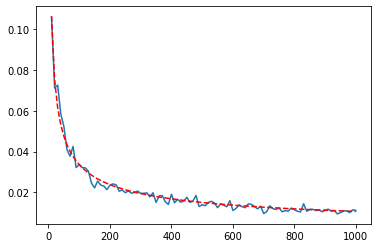

In [10]:
num_of_polys = 100
num_of_points = 100

n = np.linspace(10, 1000, num_of_points, dtype=int)
error = np.zeros(num_of_points)
for j in range(num_of_polys):
    c = np.random.rand(4)
    f = lambda x: c[0] * x**3 + c[1] * x**2 + c[2]* x + c[3]
    true = c[0]/4. + c[1]/3. + c[2]/2. + c[3]
    
    for i in range(num_of_points):
        error[i] += abs(monte_carlo_on_unit_interval(f, n[i]) - true)/float(num_of_polys)


inv_sqrt = lambda x, a: a / np.sqrt(x)
a_opt = curve_fit(inv_sqrt, n, error, 1)[0][0]
plt.plot(n, error)
plt.plot(n, inv_sqrt(n, a_opt), 'r--')

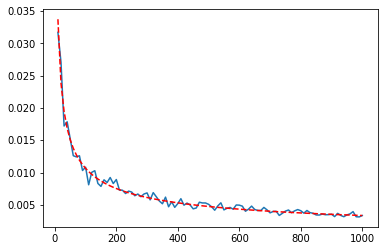

In [11]:
num_of_polys = 100
num_of_points = 100

n = np.linspace(10, 1000, num_of_points, dtype=int)
error = np.zeros(num_of_points)
for j in range(num_of_polys):
    c = np.random.rand(6)
    f = lambda x, y: c[0] * (x**2) + c[1] * (y**2) + c[2]* (np.multiply(x, y)) + c[3]* x + c[4] * y + c[5]
    true = c[0]/12 + c[1]/12 + c[2]/24 + c[3]/6 + c[4]/6 + c[5]/2
    
    for i in range(num_of_points):
        error[i] += abs(monte_carlo_on_ref_trig(f, n[i]) - true)/float(num_of_polys)


inv_sqrt = lambda x, a: a / np.sqrt(x)
a_opt = curve_fit(inv_sqrt, n, error, 1)[0][0]
plt.plot(n, error)
plt.plot(n, inv_sqrt(n, a_opt), 'r--')

All the test passes, meaning that the potential floating-point-errors is within an acceptable level for those methods. Also the monte-carlo methods accuracy was propotional to $\frac{1}{\sqrt{n}}$, as expected.

# **Discussion**

The results are not too supricing since most methods are mathematically exact and should only be able to give the exact and correct answer. Intresting is though how the Monte-Carlo methods follows the accuracy proportional to $\frac{1}{\sqrt{n}}$ strikingly well.